In [1]:
import logging
import torch
from torch import nn
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceEnum_ELBO, Trace_ELBO, config_enumerate, infer_discrete
from pyro.optim import ClippedAdam
from pyro.ops.indexing import Vindex
import os
import nltk
import collections
import re
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time

<h2> Data pre-processing </h2>

In [2]:
#Data Assimilation
knowngrp = collections.deque()
data = collections.deque()
for root, folder, files in os.walk("./data/summaries"):
    if len(folder)!=0: continue
    for file in files:
        txt = " ".join(open(root+"/"+file, "r").readlines())
        data.append(txt)
        knowngrp.append(root.split("/")[-1])       

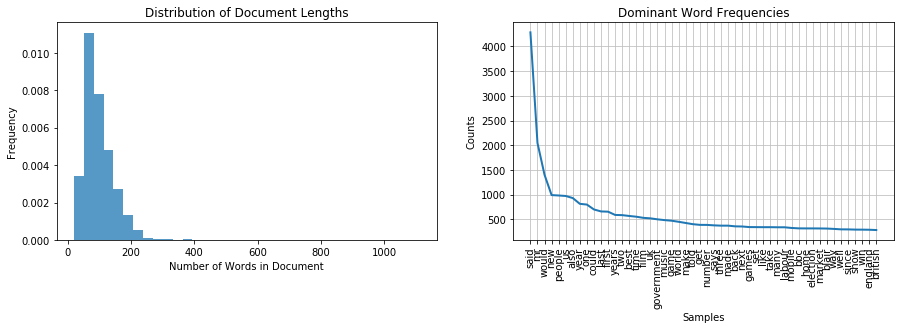

In [3]:
#Data Cleaning
en_stop = set(nltk.corpus.stopwords.words('english'))
for i in range(len(data)):
    txt = re.sub("\."," \. ",data[i])
    txt = re.sub("[^a-zA-Z0-9 ]","",txt)
    txt = txt.lower().split()
    data[i] = [elem for elem in txt if elem not in en_stop and len(elem)>1]
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
lengths = [len(txt) for txt in data]
pd.Series(lengths).plot(kind="hist",bins=35,alpha=0.75, density=True)
plt.xlabel("Number of Words in Document")
plt.title("Distribution of Document Lengths")
plt.subplot(1,2,2)
plt.title("Dominant Word Frequencies")
nltk.probability.FreqDist([word for txt in data for word in txt]).plot(50)
plt.show()

In [4]:
#Sample fewer articles (50 from each known group) and enforce a max-len of 150
np.random.seed(1)
vals = np.unique(knowngrp)
arr = np.zeros(len(vals)*50, dtype=np.int64)
for i in range(len(vals)):
    chc = np.random.choice(np.where(np.array(knowngrp)==vals[i])[0], 50)
    arr[(i*50):((i+1)*50)] = chc
knowngrp = np.array(knowngrp)[arr]
data = [data[i] for i in arr]

In [5]:
#Final Wrangling for DESIGN 1
wordnum, worddict = 0, {}
for i in range(len(data)):
    for j in range(len(data[i])):
        if worddict.get(data[i][j],None) is None:
            worddict[data[i][j]] = wordnum
            wordnum+=1
        data[i][j] = worddict[data[i][j]]
    data[i] = torch.tensor(data[i])

In [5]:
#Final Wrangling for DESIGN 2
for i in range(len(data)):
    if len(data[i])>150:
        data[i] = np.random.choice(data[i],150,replace=False)
    else:
        data[i] = np.concatenate([np.array(data[i]), np.random.choice(data[i],150-len(data[i]),replace=True)])
wordnum, worddict = 0, {}
for i in range(len(data)):
    for j in range(len(data[i])):
        if worddict.get(data[i][j],None) is None:
            worddict[data[i][j]] = wordnum
            wordnum+=1
        data[i][j] = worddict[data[i][j]]
data = np.array(data, dtype=np.int64)
data = torch.tensor(data)
data.shape

torch.Size([250, 150])

<h2> Pyro Model Design 1 - Sequential Plating

In [6]:
def model(data, N, K, V):
    eta = torch.ones(K,V)/V
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(eta))
    alpha = torch.ones(N,K)/K
    for n in pyro.plate('document_loop',N):
        theta = pyro.sample('document_topic_{n}'.format(n=n), dist.Dirichlet(alpha[n]))
        with pyro.plate('word_loop_{n}'.format(n=n), len(data[n])):
            z = pyro.sample('z_{n}'.format(n=n), dist.Categorical(theta))
            pyro.sample('wrd_{n}'.format(n=n), dist.Categorical(beta[z]), obs=data[n])

In [7]:
def guide(data, N, K, V):
    etaparam = pyro.param('eta_param', torch.ones(K,V)/V, constraint=constraints.positive)
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(etaparam))
    alphaparam = pyro.param('alpha_param', torch.ones(N,K)/K, constraint=constraints.positive)
    for n in pyro.plate('document_loop', N):
        theta = pyro.sample('document_topic_{n}'.format(n=n), dist.Dirichlet(alphaparam[n]))
        with pyro.plate('word_loop_{n}'.format(n=n), len(data[n])):
            z = pyro.sample('z_{n}'.format(n=n), dist.Categorical(theta))

In [8]:
adam_params = {"lr":0.01, "betas":(0.90,0.999)}
optimizer = pyro.optim.Adam(adam_params)
elbo = Trace_ELBO(max_plate_nesting=2)
pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=elbo)
losses = collections.deque()
start = time.time()
for i in range(2000):
    loss = svi.step(data, len(data), 5, len(worddict))
    losses.append(loss)
    if (i+1)%200==0:
        print("Epoch Update at Step "+str(i+1)+" with loss "+str(round(loss,5))+" in "+
              str(round(time.time()-start))+" seconds")
pyro.get_param_store().save("./ldapyro.cst")

Epoch Update at Step 200 with loss 337105.3044 in 1085 seconds
Epoch Update at Step 400 with loss 264002.38426 in 2168 seconds
Epoch Update at Step 600 with loss 198186.52767 in 3250 seconds
Epoch Update at Step 800 with loss 180318.15337 in 4337 seconds
Epoch Update at Step 1000 with loss 125839.47053 in 5418 seconds
Epoch Update at Step 1200 with loss 164767.57878 in 6499 seconds
Epoch Update at Step 1400 with loss 157771.27192 in 7585 seconds
Epoch Update at Step 1600 with loss 119125.39976 in 8672 seconds
Epoch Update at Step 1800 with loss 111942.27325 in 9750 seconds
Epoch Update at Step 2000 with loss 136063.29062 in 10831 seconds


In [10]:
for i in range(2000,3600):
    loss = svi.step(data, len(data), 5, len(worddict))
    losses.append(loss)
    if (i+1)%200==0:
        print("Epoch Update at Step "+str(i+1)+" with loss "+str(round(loss,5))+" in "+
              str(round(time.time()-start))+" seconds")

Epoch Update at Step 2200 with loss 129606.29496 in 15961 seconds
Epoch Update at Step 2400 with loss 122982.7077 in 17057 seconds
Epoch Update at Step 2600 with loss 116408.51135 in 18158 seconds
Epoch Update at Step 2800 with loss 109811.07888 in 19282 seconds
Epoch Update at Step 3000 with loss 101556.3783 in 20408 seconds
Epoch Update at Step 3200 with loss 93121.39589 in 21500 seconds
Epoch Update at Step 3400 with loss 85858.57311 in 22582 seconds
Epoch Update at Step 3600 with loss 75872.49793 in 23671 seconds


In [11]:
pyro.get_param_store().save("./ldapyro.cst")

<h2>Pyro Model Design 2 - Vectorized Plating with Enumeration

In [6]:
def model(N, K, V, LN, data=None):
    eta = torch.ones(K,V)/V
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(eta))
    alpha = torch.ones(N,K)/K
    with pyro.plate('document_loop',N):
        theta = pyro.sample('document_topic', dist.Dirichlet(alpha))
        with pyro.plate('word_loop', LN):
            z = pyro.sample('z', dist.Categorical(theta), infer={"enumerate": "parallel"})
            w = pyro.sample('wrd', dist.Categorical(Vindex(beta)[z]), obs=data)

In [7]:
def guide(N, K, V, LN, data=None):
    etaparam = pyro.param('eta_param', torch.ones(K,V)/V, constraint=constraints.positive)
    with pyro.plate('topic_loop',K):
        beta = pyro.sample('vocab_beta', dist.Dirichlet(etaparam))
    alphaparam = pyro.param('alpha_param', torch.ones(N,K)/K, constraint=constraints.positive)
    with pyro.plate('document_loop', N):
        theta = pyro.sample('document_topic', dist.Dirichlet(alphaparam))

In [ ]:
adam_params = {"lr":0.01, "betas":(0.90,0.999)}
optimizer = pyro.optim.Adam(adam_params)
elbo = TraceEnum_ELBO(max_plate_nesting=2)
pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=elbo)
losses = collections.deque()
start = time.time()
for i in range(3):
    loss = svi.step(250,5,len(worddict),150,data.T)
    losses.append(loss)
    #if (i+1)%100==0:
    #    print("Epoch Update at Step "+str(i+1)+" with loss "+str(round(loss,5))+" in "+
    #          str(round(time.time()-start))+" seconds")
print(time.time()-start)
#pyro.get_param_store().save("./ldapyro1.cst")

In [9]:
losses

deque([595931.0, 595493.1875, 595317.625])

In [13]:
for name in pyro.get_param_store().get_all_param_names():
    print(name, pyro.param(name).data.numpy())

eta_param [[3.33421497e-07 3.80402003e-06 6.87036163e-07 ... 2.40203974e-07
  2.04676439e-07 2.93032286e-07]
 [1.42031141e-07 5.71227283e-05 5.43624594e-07 ... 7.04463545e-08
  8.64121716e-08 7.78530662e-08]
 [2.13597417e-07 1.29774298e-06 8.29381634e-07 ... 1.82789307e-07
  1.98382054e-07 1.39712910e-07]
 [1.15042695e-07 4.24875907e-05 1.44675909e-07 ... 1.53114840e-07
  7.02930762e-08 5.94322032e-08]
 [2.52612494e-07 9.67444294e-07 3.98336937e-07 ... 1.30306006e-07
  1.49029162e-07 1.49033283e-07]]
alpha_param [[0.25627887 0.23316531 0.22160277 0.17567563 0.29367208]
 [0.25310785 0.21087883 0.19383824 0.19228956 0.16989852]
 [0.18071312 0.16005272 0.14753446 0.2956003  0.20591828]
 ...
 [0.24954355 0.34651458 0.18127164 0.13094735 0.16816938]
 [0.18054406 0.19935107 0.23903084 0.1432329  0.24826428]
 [0.11663691 0.24203688 0.2539011  0.17880589 0.19603807]]


<h2> Model Results </h2>